## **Imports**

In [1]:
# Imports
import pandas as pd  # Data manipulation and analysis
import numpy as np   # Support for large, multi-dimensional arrays and matrices
import os            # Interfacing with the operating system
%pip install lxml    # Install lxml library for XML and HTML processing
from lxml import etree  # XML and HTML manipulation
%pip install requests # Install requests library for HTTP operations
import requests      # Library to make HTTP requests
import xml.etree.ElementTree as ET  # XML parsing and manipulation
from collections import defaultdict  # Dictionary that provides a default value for missing keys
import seaborn as sns
import matplotlib.pyplot as plt


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## **Load and inspect data**

In [22]:
# Load from csv
person = pd.read_csv('data/Person Person.csv', delimiter=',')
customer = pd.read_csv('data/Sales Customer (1).csv', delimiter=',')
sales = pd.read_csv('data/Sales SalesOrderHeader (1).csv', delimiter=',')
linking_table = pd.read_csv('data/Person BusinessEntityContact.csv', delimiter=',')

# Inspect columns
person.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19972 entries, 0 to 19971
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   BusinessEntityID       19972 non-null  int64 
 1   PersonType             19972 non-null  object
 2   NameStyle              19972 non-null  bool  
 3   Title                  1009 non-null   object
 4   FirstName              19972 non-null  object
 5   MiddleName             11473 non-null  object
 6   LastName               19972 non-null  object
 7   Suffix                 53 non-null     object
 8   EmailPromotion         19972 non-null  int64 
 9   AdditionalContactInfo  10 non-null     object
 10  Demographics           19972 non-null  object
 11  rowguid                19972 non-null  object
 12  ModifiedDate           19972 non-null  object
dtypes: bool(1), int64(2), object(10)
memory usage: 1.8+ MB


In [4]:
# Inspect data
person.head()

,BusinessEntityID,PersonType,NameStyle,Title,FirstName,MiddleName,LastName,Suffix,EmailPromotion,AdditionalContactInfo,Demographics,rowguid,ModifiedDate
0,1722,IN,False,NaN,Mandar,NaN,Samant,NaN,0,NaN,"<IndividualSurvey xmlns=""http://schemas.micros...",6F123B92-FF1E-4F18-A054-F1477D965B36,2013-04-08 00:00:00.000
1,2389,IN,False,NaN,Laura,NaN,Liu,NaN,0,NaN,"<IndividualSurvey xmlns=""http://schemas.micros...",0BB7741C-53C5-4502-AABC-AA3E798EC6E7,2013-09-04 00:00:00.000
2,2391,IN,False,NaN,Laura,NaN,Wu,NaN,0,NaN,"<IndividualSurvey xmlns=""http://schemas.micros...",D2535AEE-7780-4CAC-9737-5D23895FD5B5,2012-04-20 00:00:00.000
3,2397,IN,False,NaN,Isabella,NaN,Cox,NaN,0,NaN,"<IndividualSurvey xmlns=""http://schemas.micros...",09FB996B-2BD4-454F-A9D2-F0F307D13039,2013-10-06 00:00:00.000
4,2401,IN,False,NaN,Laura,NaN,Gao,NaN,0,NaN,"<IndividualSurvey xmlns=""http://schemas.micros...",D319CB69-2139-4F0C-AEA6-541B3D5B0412,2014-05-15 00:00:00.000


> ☝ **Findings** and⚡ **Actions**:

1. There are a number of columns with high proportions of missing values: `Title`, `Suffix`, `AdditionalContactInfo`. Based on the column names, it's unlikely these will be useful for segmentation so I can remove them. 
2. Columns recording name information (`Firstname`, `MiddleName`, `LastName`) won't be needed for this project either, so I can remove these too. 
3. The `PersonType` column contains descriptive labels about each person's relationship to AdventureWorks. For initial analysis, I'll concentrate on "individual customers" (those with an "IN" value) so I'll subset out these individuals. 
4. The `Demographics` column contains XML values with demographic information that will be useful for segmentation. In order to work with the information, I'll need to extract it from XML format into structured columns.  

## **Subset and prepare data**

In [3]:
# Drop columns
person = person.drop(['NameStyle',
                      'Title',
                      'FirstName',
                      'MiddleName',
                      'LastName',
                      'Suffix',
                      'AdditionalContactInfo'], axis = 1)

# Subset individual customers
person_in = person[person['PersonType']=='IN']

# Drop PersonType column, which is no longer needed
person_in = person_in.drop('PersonType', axis = 1)

# Reset row indices to allow for concatenation later
person_in.reset_index(inplace=True, drop=True)

# Inspect data
person_in.head()


,BusinessEntityID,EmailPromotion,Demographics,rowguid,ModifiedDate
0,1722,0,"<IndividualSurvey xmlns=""http://schemas.micros...",6F123B92-FF1E-4F18-A054-F1477D965B36,2013-04-08 00:00:00.000
1,2389,0,"<IndividualSurvey xmlns=""http://schemas.micros...",0BB7741C-53C5-4502-AABC-AA3E798EC6E7,2013-09-04 00:00:00.000
2,2391,0,"<IndividualSurvey xmlns=""http://schemas.micros...",D2535AEE-7780-4CAC-9737-5D23895FD5B5,2012-04-20 00:00:00.000
3,2397,0,"<IndividualSurvey xmlns=""http://schemas.micros...",09FB996B-2BD4-454F-A9D2-F0F307D13039,2013-10-06 00:00:00.000
4,2401,0,"<IndividualSurvey xmlns=""http://schemas.micros...",D319CB69-2139-4F0C-AEA6-541B3D5B0412,2014-05-15 00:00:00.000


> ☝ **Findings** and⚡ **Actions**:

1. The `Demographics` column is in XML; a flexible format for storing data in a tree-like structure. 
2. I need to parse the XML values and extract data into new columns. The function below is designed to do that. 

In [4]:
# Function to parse XML and extract all items
def xml_to_columns(xml_string):
    # Namespace for schema
    ns = {'aw': 'http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/IndividualSurvey'}
    
    # Parse the XML string into a tree structure
    tree = ET.fromstring(xml_string)
    
    # Initialize a dictionary to store items, defaulting missing entries to None
    items = defaultdict(lambda: None)
    
    # Iterate through each element in the XML tree, using the namespace map
    for element in tree.findall('.//aw:*', namespaces=ns):
        # Extract the tag and remove the namespace information for clarity
        tag = element.tag.split('}')[-1]  
        # Store the element's text content under the tag in the items dictionary
        items[tag] = element.text
    
    return pd.Series(items)

In [5]:
# Apply the function 
extracted_xml_columns = person_in['Demographics'].apply(xml_to_columns)

# Concatenate the newly columns back onto the original dataframe
person_in = person_in.join(extracted_xml_columns)

# Drop the original Demographics columns, which is no longer needed
person_in = person_in.drop(['Demographics'], axis = 1)

# Inspect
person_in.head()

,BusinessEntityID,EmailPromotion,rowguid,ModifiedDate,TotalPurchaseYTD,DateFirstPurchase,BirthDate,MaritalStatus,YearlyIncome,Gender,TotalChildren,NumberChildrenAtHome,Education,Occupation,HomeOwnerFlag,NumberCarsOwned,CommuteDistance
0,1722,0,6F123B92-FF1E-4F18-A054-F1477D965B36,2013-04-08 00:00:00.000,3499.8504,2003-05-10Z,1974-09-18Z,S,0-25000,F,0,0,Partial High School,Manual,0,2,0-1 Miles
1,2389,0,0BB7741C-53C5-4502-AABC-AA3E798EC6E7,2013-09-04 00:00:00.000,1085.5,2003-10-06Z,1967-10-05Z,S,25001-50000,F,5,5,High School,Skilled Manual,1,3,10+ Miles
2,2391,0,D2535AEE-7780-4CAC-9737-5D23895FD5B5,2012-04-20 00:00:00.000,36.59,2002-05-22Z,1973-10-21Z,S,greater than 100000,F,0,5,Partial College,Management,1,3,10+ Miles
3,2397,0,09FB996B-2BD4-454F-A9D2-F0F307D13039,2013-10-06 00:00:00.000,-3.99,2003-11-07Z,1978-08-28Z,S,25001-50000,F,0,0,Partial High School,Clerical,1,2,5-10 Miles
4,2401,0,D319CB69-2139-4F0C-AEA6-541B3D5B0412,2014-05-15 00:00:00.000,12.99,2004-06-15Z,1939-11-03Z,M,25001-50000,F,2,0,Bachelors,Management,1,2,5-10 Miles


> ☝ **Findings** and⚡ **Actions**:

1. After extraction from XML, values are treated as strings by default. 
2. Therefore data type conversions will be needed to make these fields suitable for further analysis.  


## **Pre-process and transform data**

In [6]:
# Inspect columns
person_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   BusinessEntityID      18484 non-null  int64 
 1   EmailPromotion        18484 non-null  int64 
 2   rowguid               18484 non-null  object
 3   ModifiedDate          18484 non-null  object
 4   TotalPurchaseYTD      18484 non-null  object
 5   DateFirstPurchase     18484 non-null  object
 6   BirthDate             18484 non-null  object
 7   MaritalStatus         18484 non-null  object
 8   YearlyIncome          18484 non-null  object
 9   Gender                18484 non-null  object
 10  TotalChildren         18484 non-null  object
 11  NumberChildrenAtHome  18484 non-null  object
 12  Education             18484 non-null  object
 13  Occupation            18484 non-null  object
 14  HomeOwnerFlag         18484 non-null  object
 15  NumberCarsOwned       18484 non-null

> ☝ **Findings** and⚡ **Actions**:

As expected, all the newly extracted fields are `object` type. After checking the values, these are the data type transformations needed to make them suitable for modelling. 

1. **Floats**
    - `TotalPurchaseYTD`

2. **Dates**
    - `DateFirstPurchase`	
    - `BirthDate`
    - `ModifiedDate`

3. **Categories**
    - `EmailPromotion` # This feature is not from the XML string but it should be represented as a category instead of int
    - `BusinessEntityID`
    - `MaritalStatus`	
    - `YearlyIncome`	
    - `Gender`
    - `Education`	
    - `Occupation`
    - `CommuteDistance`

4. **Integers**
    - `TotalChildren`	
    - `NumberChildrenAtHome`
    - `HomeOwnerFlag`	
    - `NumberCarsOwned`


Additionally, some of these values will not be very useful in their raw form but can be used to derive more meaningful features (eg, customer birthdays are less useful than age for understanding behaviour). After data type conversions, I should perform some feature development. 

### Data type conversions

In [7]:
# Float conversions
person_in['TotalPurchaseYTD'] = person_in['TotalPurchaseYTD'].astype(float)

# Datetime conversions
person_in['DateFirstPurchase'] = pd.to_datetime(person_in['DateFirstPurchase'], format='%Y-%m-%dZ')
person_in['BirthDate'] = pd.to_datetime(person_in['BirthDate'], format='%Y-%m-%dZ')
person_in['ModifiedDate'] = pd.to_datetime(person_in['ModifiedDate'])

# Category conversions
person_in['BusinessEntityID'] = person_in['BusinessEntityID'].astype('category')
person_in['MaritalStatus'] = person_in['MaritalStatus'].astype('category')
person_in['YearlyIncome'] = person_in['YearlyIncome'].astype('category')
person_in['Gender'] = person_in['Gender'].astype('category')
person_in['Education'] = person_in['Education'].astype('category')
person_in['Occupation'] = person_in['Occupation'].astype('category')
person_in['CommuteDistance'] = person_in['CommuteDistance'].astype('category')

# Define promotional email mapping dict
promo_email_mapping_dict = {
    0: 'no_email_promos',
    1: 'aw_email_promos',
    2: 'aw_plus_email_promos'
}
# Apply promo email mapping dict
person_in['EmailPromotion'] = person_in['EmailPromotion'].replace(promo_email_mapping_dict)

# Category conversion
person_in['EmailPromotion'] = person_in['EmailPromotion'].astype('category')

# Integer conversions
person_in['TotalChildren'] = person_in['TotalChildren'].astype(int)
person_in['NumberChildrenAtHome'] = person_in['NumberChildrenAtHome'].astype(int)
person_in['HomeOwnerFlag'] = person_in['HomeOwnerFlag'].astype(int)
person_in['NumberCarsOwned'] = person_in['NumberCarsOwned'].astype(int)

# Inspect
person_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   BusinessEntityID      18484 non-null  category      
 1   EmailPromotion        18484 non-null  category      
 2   rowguid               18484 non-null  object        
 3   ModifiedDate          18484 non-null  datetime64[ns]
 4   TotalPurchaseYTD      18484 non-null  float64       
 5   DateFirstPurchase     18484 non-null  datetime64[ns]
 6   BirthDate             18484 non-null  datetime64[ns]
 7   MaritalStatus         18484 non-null  category      
 8   YearlyIncome          18484 non-null  category      
 9   Gender                18484 non-null  category      
 10  TotalChildren         18484 non-null  int64         
 11  NumberChildrenAtHome  18484 non-null  int64         
 12  Education             18484 non-null  category      
 13  Occupation      

### Feature extraction

In [8]:
def calculate_age(birthdate, reference_date):
    """
    Calculate age in years from birthdate to a given reference date.

    Args:
    birthdate (pd.Series): Pandas Series of birth dates.
    reference_date (pd.Timestamp): The date from which to calculate the age.

    Returns:
    pd.Series: Age in years on the reference date.
    """
    return (reference_date - birthdate).dt.days // 365

def days_since_date(first_purchase_date, reference_date):
    """
    Calculate time in days since the first purchase date to a given reference date.

    Args:
    first_purchase_date (pd.Series): Pandas Series of first purchase dates.
    reference_date (pd.Timestamp): The date from which to calculate the years since first purchase.

    Returns:
    pd.Series: Days from first purchase to the reference date.
    """
    return (reference_date - first_purchase_date).dt.days 


In [9]:
# Set a reference date
reference_date = pd.Timestamp('2024-01-01') 

# Apply the functions to calculate age and time in days since first purchase
person_in['Age'] = calculate_age(person_in['BirthDate'], reference_date)
person_in['DaysSinceFirstPurchase'] = days_since_date(person_in['DateFirstPurchase'], reference_date)

# Calculate years since first purchase as a more intuitive measure
person_in['YearsSinceFirstPurchase'] = person_in['DaysSinceFirstPurchase'] / 365

# Drop columns
person_in = person_in.drop(['BirthDate', 'DateFirstPurchase', 'ModifiedDate', 'DaysSinceFirstPurchase'], axis = 1)

# Inspect
person_in.head()

,BusinessEntityID,EmailPromotion,rowguid,TotalPurchaseYTD,MaritalStatus,YearlyIncome,Gender,TotalChildren,NumberChildrenAtHome,Education,Occupation,HomeOwnerFlag,NumberCarsOwned,CommuteDistance,Age,YearsSinceFirstPurchase
0,1722,no_email_promos,6F123B92-FF1E-4F18-A054-F1477D965B36,3499.8504,S,0-25000,F,0,0,Partial High School,Manual,0,2,0-1 Miles,49,20.660274
1,2389,no_email_promos,0BB7741C-53C5-4502-AABC-AA3E798EC6E7,1085.5000,S,25001-50000,F,5,5,High School,Skilled Manual,1,3,10+ Miles,56,20.252055
2,2391,no_email_promos,D2535AEE-7780-4CAC-9737-5D23895FD5B5,36.5900,S,greater than 100000,F,0,5,Partial College,Management,1,3,10+ Miles,50,21.627397
3,2397,no_email_promos,09FB996B-2BD4-454F-A9D2-F0F307D13039,-3.9900,S,25001-50000,F,0,0,Partial High School,Clerical,1,2,5-10 Miles,45,20.164384
4,2401,no_email_promos,D319CB69-2139-4F0C-AEA6-541B3D5B0412,12.9900,M,25001-50000,F,2,0,Bachelors,Management,1,2,5-10 Miles,84,19.558904


## **Exploratory Data Analysis**

We can perform some exploratory data analysis to better understand the data. 

### Number of unique individuals

In [10]:
n_records = person_in.shape[0]
n_individuals = person_in.BusinessEntityID.nunique()
n_duplicates = person_in.drop(columns=['BusinessEntityID']).duplicated(keep=False).sum()

print(f"""
      Number of records: {n_records}
      Number of unique IDS: {n_individuals}
      Number of duplicates (not including unique ID): {n_duplicates}
      """)


      Number of records: 18484
      Number of unique IDS: 18484
      Number of duplicates (not including unique ID): 0
      


> ☝ **Findings** and⚡ **Actions**:

1. There are approximately 18,400 unique customers included in this dataset. 
2. There are no duplicate records and no action needs to be taken. 

### Individuals receiving promotional emails

/tmp/ipykernel_1744/3540824660.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=promo_email_values.index,


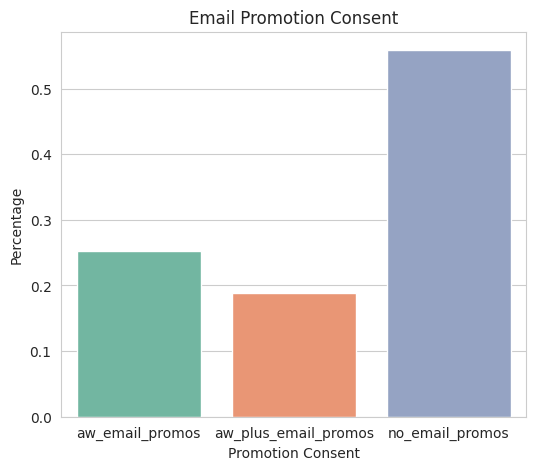

EmailPromotion
no_email_promos         0.558916
aw_email_promos         0.252489
aw_plus_email_promos    0.188596
Name: proportion, dtype: float64

In [11]:
# Extract promotional email preference value counts
promo_email_values = person_in.EmailPromotion.value_counts(normalize=True)

# Setting the seaborn style to "whitegrid" for better grid visibility
sns.set_style("whitegrid")

# Plot the values using seaborn barplot
plt.figure(figsize=(6, 5))
sns.barplot(x=promo_email_values.index,
            y=promo_email_values.values, palette='Set2')
plt.title('Email Promotion Consent')
plt.xlabel('Promotion Consent')
plt.ylabel('Percentage')
plt.show()

# Print values too 
promo_email_values

> ☝ **Findings** and⚡ **Actions**:

1. Slightly over half customers have opted out of promotional emails, around a quarter have opted in to promotional emails from Adventure Works, and around 19% have opted in to emails from both Adventure Works and selected partners. 
2. This could be valuable information for segmentation, assuming that customers who have opted in to promotional emails are more engaged with Adventure Works and may have different spending habits. 
3. I'll examine TotalPurchaseYTD for each of these groups to check this.

/tmp/ipykernel_1744/3417089161.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='EmailPromotion', y='TotalPurchaseYTD', data=person_in, palette='Set2')


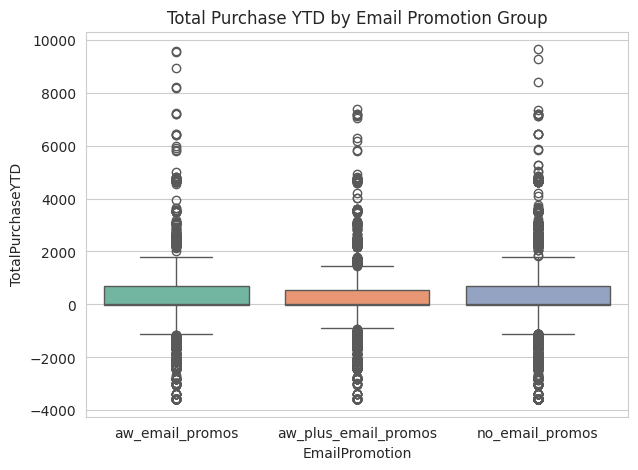

In [12]:
# Plot distributions of TotalPurchaseYTD per group
sns.set_style("whitegrid")  
plt.figure(figsize=(7, 5))
sns.boxplot(x='EmailPromotion', y='TotalPurchaseYTD', data=person_in, palette='Set2')
plt.title('Total Purchase YTD by Email Promotion Group')
plt.show()

> ☝ **Findings** and⚡ **Actions**:

1. Interestngly, there are large numbers of negative spend values for each group. This could indicate that `TotalPurchaseYTD` column records profit and not purchase amount, and that these customers recieved a number of refunds. Or, more likely, that these negative values are errors which need to be corrected or excluded. 
2. In a real business setting it would be crucial to investigate these values in more detail, but for the purposes of this analysis I'll assume they are mistakes and remove them. 

/tmp/ipykernel_1744/3118851528.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='EmailPromotion', y='TotalPurchaseYTD', data=person_in_filtered, palette='Set2')


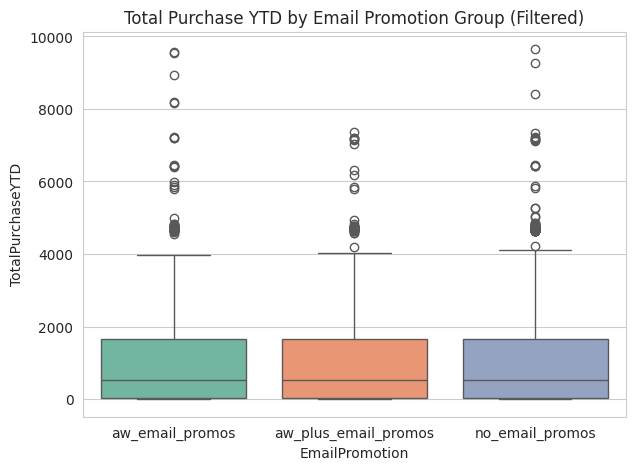


      Customers excluded: 7580
      Remaining customers: 10904



In [13]:
# Exclude rows where TotalPurchaseYTD is less than 0
person_in_filtered = person_in[person_in['TotalPurchaseYTD'] >= 0]

# Plot distributions of TotalPurchaseYTD per group
sns.set_style("whitegrid")  
plt.figure(figsize=(7, 5))
sns.boxplot(x='EmailPromotion', y='TotalPurchaseYTD', data=person_in_filtered, palette='Set2')
plt.title('Total Purchase YTD by Email Promotion Group (Filtered)')
plt.show()

# Check number of reocrds excluded by filtering
print(f"""
      Customers excluded: {person_in.shape[0] - person_in_filtered.shape[0]}
      Remaining customers: {person_in_filtered.shape[0]}
""")

> ☝ **Findings** and⚡ **Actions**:

1. The range and median values for all groups look very similar, indicating that promotional emails do not significantly affect purchasing on average. 
2. The presence of outliers for all groups shows that there are a number of "high value" customers. These will be a valuable segment to understand in further analysis. 

### Year to date purchase amount

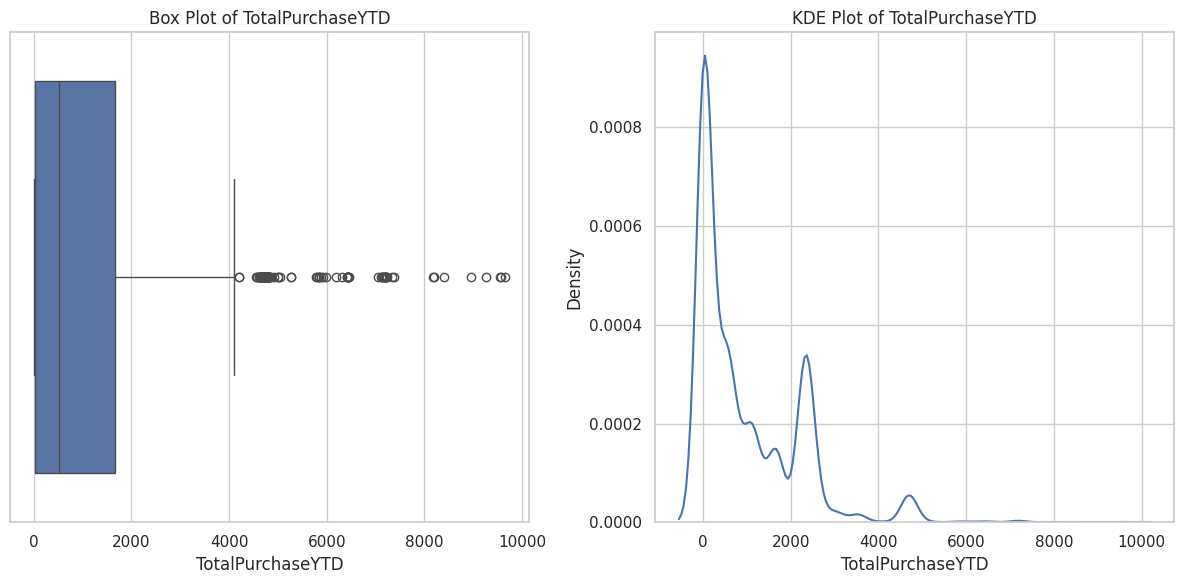

count    10904.000000
mean       949.513152
std       1177.739444
min          0.000000
25%         30.310000
50%        518.981800
75%       1666.000000
max       9650.760000
Name: TotalPurchaseYTD, dtype: float64

In [14]:
# Set whitegrid as the aesthetic style again 
sns.set(style="whitegrid")

# Create subplots for side-by-side plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Boxplot on the first subplot
sns.boxplot(x=person_in_filtered['TotalPurchaseYTD'], ax=axes[0])
axes[0].set_title('Box Plot of TotalPurchaseYTD')

# KDE plot on the second subplot
sns.kdeplot(person_in_filtered['TotalPurchaseYTD'], ax=axes[1])
axes[1].set_title('KDE Plot of TotalPurchaseYTD')

# Adjust subplots to ensure no overlap 
plt.tight_layout()

# Display the plots
plt.show()

# Print distribution for reference too
person_in_filtered.TotalPurchaseYTD.describe()

> ☝ **Findings** and⚡ **Actions**:

1. The median year to date purchase is $518. The mean is considerably higher at $949, due to the influence of those outliers identified earlier. 
2. The interquartile range is betwene $30 and $1,666 - so half the customers' YTD purchase amounts fall within this range. 
3. There is a 'spike' of customers with YTD purchase amounts around $2,000, with another smaller spike at $4,000. 
4. From a business perspective, customer spend will likely be one of the most important behavioural traits to model and segment on, so I'll perform some additional analysis for TotalPurchaseYTD, looking for relationships with other variables.

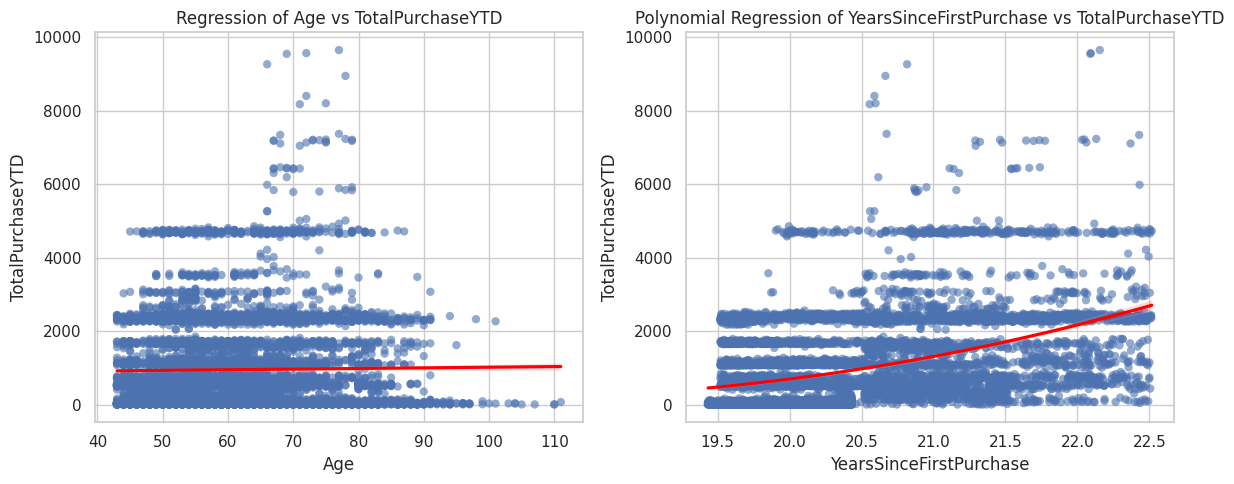

In [15]:
# Create a figure to hold the subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figure size as needed

# Regplot for Age vs. TotalPurchaseYTD
sns.regplot(x='Age', y='TotalPurchaseYTD', data=person_in_filtered, ax=axes[0], scatter_kws={'alpha': 0.6, 'edgecolor': 'none'}, line_kws={'color': 'red'}, order=1)
axes[0].set_title('Regression of Age vs TotalPurchaseYTD')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('TotalPurchaseYTD')

# Polynomial Regplot for YearsSinceFirstPurchase vs. TotalPurchaseYTD
sns.regplot(x='YearsSinceFirstPurchase', y='TotalPurchaseYTD', data=person_in_filtered, ax=axes[1], scatter_kws={'alpha': 0.6, 'edgecolor': 'none'}, line_kws={'color': 'red'}, order=2)
axes[1].set_title('Polynomial Regression of YearsSinceFirstPurchase vs TotalPurchaseYTD')
axes[1].set_xlabel('YearsSinceFirstPurchase')
axes[1].set_ylabel('TotalPurchaseYTD')

# Automatically adjust subplot parameters to give specified padding
plt.tight_layout()
plt.show()


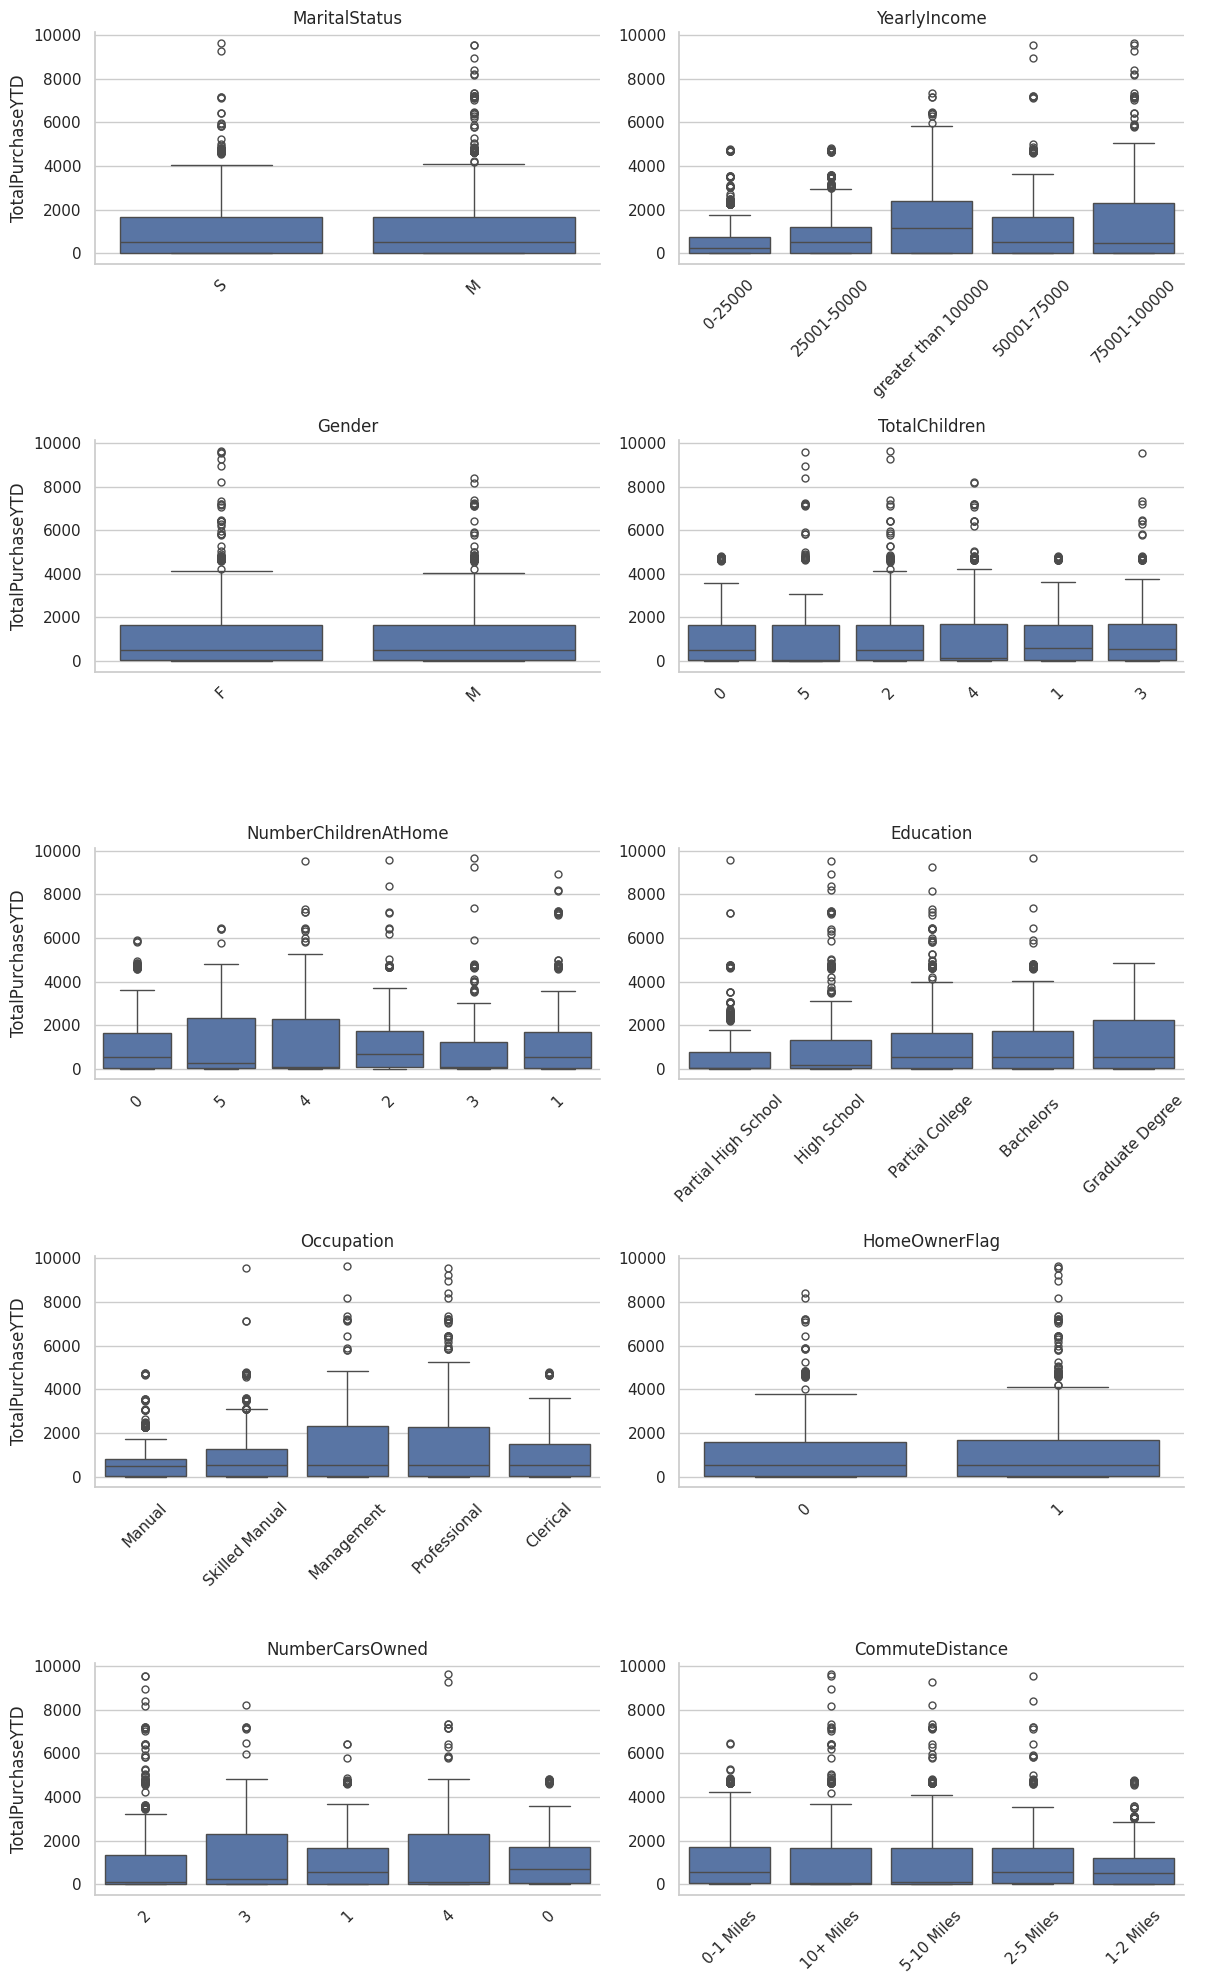

In [16]:
# Assuming 'df' is your DataFrame containing the data
cat_variables_to_plot_against = ['MaritalStatus', 'YearlyIncome', 'Gender', 
                                 'TotalChildren', 'NumberChildrenAtHome', 'Education', 'Occupation', 
                                 'HomeOwnerFlag', 'NumberCarsOwned', 'CommuteDistance']

# Melt the DataFrame
df_melted = person_in_filtered.melt(id_vars='TotalPurchaseYTD', value_vars=cat_variables_to_plot_against)

# Create a catplot for each categorical variable against TotalPurchaseYTD
g = sns.catplot(x='value', y='TotalPurchaseYTD', col='variable', data=df_melted,
                kind='box', col_wrap=2, height=4, aspect=1.5, sharex=False, sharey=False)

# Set the titles and adjust the axes for better visualization
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)  # Rotate x-axis labels to make them more legible
g.set_axis_labels("", "TotalPurchaseYTD")

# Adjust layout
plt.tight_layout()
plt.show()

> ☝ **Findings** and⚡ **Actions**:

1. Although there is no clear linear relationship between Age and YTD purchase amount, there is a cluster of high-spending customers between the 65-80. 
2. There is a weak to moderate quadratic polynomial relationship between years since first purchase and purchase amount, suggesting that long-standing customers spend more on average. 
3. Customers' yearly purchase amounts seem to increase as their income, level of education and role seniority increases. It is to be expected that these variables will have some degree of correlation. 
4. Marital status, gender and home ownership do not show any obvious differences in purchase amounts between their categorical options.
5. There appear to be differences in purchase amounts according to total children, number of children at home, number of cars and commute distance, but these are not extremely strong and aren't easy to discern as the plots are not ordered correctly. I'll replot these to examine this later, but this gives some idea about potential segmentation strategies. 

### Marital status

/tmp/ipykernel_1744/1426154099.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=marital_values.index,


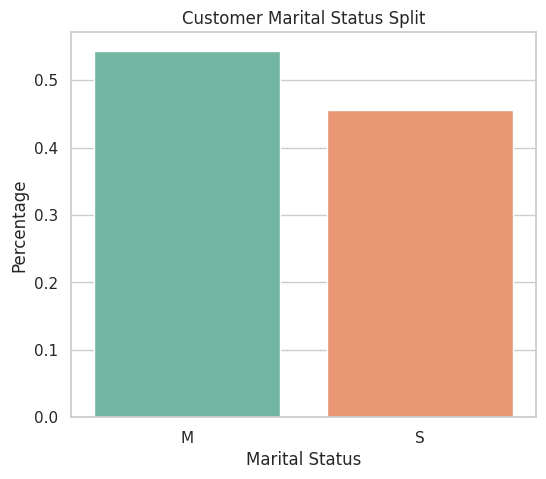

MaritalStatus
M    0.544204
S    0.455796
Name: proportion, dtype: float64

In [17]:
# Extract marital status value counts
marital_values = person_in_filtered.MaritalStatus.value_counts(normalize=True)

# Setting the seaborn style to "whitegrid" for better grid visibility
sns.set_style("whitegrid")

# Plot the values using seaborn barplot
plt.figure(figsize=(6, 5))
sns.barplot(x=marital_values.index,
            y=marital_values.values, palette='Set2')
plt.title('Customer Marital Status Split')
plt.xlabel('Marital Status')
plt.ylabel('Percentage')
plt.show()

# Print values too 
marital_values

> ☝ **Findings** and⚡ **Actions**:

1. Slightly over half of customers are married. 
2. It was observed earlier that there was not a clerly visible difference in yearly purchase amounts according to marital status.

## Segmentation

### High value customers

In a real business setting, we could determine 

In [18]:
person_in_filtered.head()

,BusinessEntityID,EmailPromotion,rowguid,TotalPurchaseYTD,MaritalStatus,YearlyIncome,Gender,TotalChildren,NumberChildrenAtHome,Education,Occupation,HomeOwnerFlag,NumberCarsOwned,CommuteDistance,Age,YearsSinceFirstPurchase
0,1722,no_email_promos,6F123B92-FF1E-4F18-A054-F1477D965B36,3499.8504,S,0-25000,F,0,0,Partial High School,Manual,0,2,0-1 Miles,49,20.660274
1,2389,no_email_promos,0BB7741C-53C5-4502-AABC-AA3E798EC6E7,1085.5000,S,25001-50000,F,5,5,High School,Skilled Manual,1,3,10+ Miles,56,20.252055
2,2391,no_email_promos,D2535AEE-7780-4CAC-9737-5D23895FD5B5,36.5900,S,greater than 100000,F,0,5,Partial College,Management,1,3,10+ Miles,50,21.627397
4,2401,no_email_promos,D319CB69-2139-4F0C-AEA6-541B3D5B0412,12.9900,M,25001-50000,F,2,0,Bachelors,Management,1,2,5-10 Miles,84,19.558904
6,2408,no_email_promos,9339CB51-FC94-426F-A99C-B1DE6B9512E7,1.6000,M,25001-50000,F,4,4,Bachelors,Skilled Manual,1,1,2-5 Miles,58,20.213699


In [20]:
customer.columns

Index(['CustomerID', 'PersonID', 'StoreID', 'TerritoryID', 'AccountNumber',
       'rowguid', 'ModifiedDate'],
      dtype='object')

In [21]:
sales.columns

Index(['SalesOrderID', 'RevisionNumber', 'OrderDate', 'DueDate', 'ShipDate',
       'Status', 'OnlineOrderFlag', 'SalesOrderNumber', 'PurchaseOrderNumber',
       'AccountNumber', 'CustomerID', 'SalesPersonID', 'TerritoryID',
       'BillToAddressID', 'ShipToAddressID', 'ShipMethodID', 'CreditCardID',
       'CreditCardApprovalCode', 'CurrencyRateID', 'SubTotal', 'TaxAmt',
       'Freight', 'TotalDue', 'Comment', 'rowguid', 'ModifiedDate'],
      dtype='object')

In [23]:
linking_table.columns

Index(['BusinessEntityID', 'PersonID', 'ContactTypeID', 'rowguid',
       'ModifiedDate'],
      dtype='object')

In [24]:
# Step 1: Merge person_in_filtered with linking_table
linked_persons = pd.merge(person_in_filtered, linking_table, on='BusinessEntityID')

# Step 2: Merge the result with the customer table
linked_customers = pd.merge(linked_persons, customer, on='PersonID')

# Step 3: Merge this result with the sales data
filtered_sales = pd.merge(linked_customers, sales, on='CustomerID')

# Now, filtered_sales contains only the sales records for customers in person_in_filtered
print(filtered_sales.head())

MergeError: Passing 'suffixes' which cause duplicate columns {'rowguid_x'} is not allowed.